In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import random
import math
import time
import torch.nn.functional as F

from tqdm.notebook import tqdm
from torch import optim
from torch.utils.data import DataLoader, Dataset,  WeightedRandomSampler
from  scipy import stats
import scipy
import numpy as np
np.random.seed(1)
torch.manual_seed(1)
random.seed(1)

In [2]:
import os
os.chdir("/content/drive/MyDrive/MADE/Project/deap")

In [3]:
def get_padding(in_size, kernel_size, stride):
    if (in_size % stride == 0):
        padding = max(kernel_size - stride, 0)
    else:
        padding = max(kernel_size - (in_size % stride), 0)
    return (padding)    

In [108]:
def get_temporal_feature_extractor(input_size):
  pad = get_padding(input_size, 5,  2)
  conv1 = nn.Conv2d(1, 32, kernel_size = (1, 5), stride=(1, 2), padding=(0, pad))
  relu1 = nn.LeakyReLU()
  pad = get_padding(input_size, 3,  2)
  conv2 = nn.Conv2d(32, 32, kernel_size = (1, 3), stride=(1, 2), padding=(0, pad))
  relu2 = nn.LeakyReLU()
  conv3 = nn.Conv2d(32, 32, kernel_size = (1, 3), stride=(1, 2), padding=(0, pad))
  relu3 = nn.LeakyReLU()
  conv4 = nn.Conv2d(32, 32, kernel_size = (1, 16), stride=(1, 16), padding=0)
  relu4 = nn.LeakyReLU()
  #print("11")
  result = torch.nn.Sequential(conv1, relu1, conv2, relu2, conv3, relu3, conv4, relu4)
  #print("22")
  #print(result)
  return(result)

In [5]:
import glob
import pickle
from sklearn.preprocessing import MinMaxScaler

data = []
labels = []
data_dir = './data_preprocessed_python'
files = glob.glob(os.path.join(data_dir, "*.dat"))
data_raw = []
for file_data in files:
    raw_data = pickle.load(open(file_data, 'rb'), encoding='latin1')
    data.append(raw_data['data'])
    #data_raw.append(raw_data['data'][:, :, :])
    # data_raw[-1][0, :32, 0]
    # print(data_raw[-1][:, :31, :].min())
    # print(data_raw[-1][:, :31, :].max())
    # scaler = MinMaxScaler()
    # for i in range(40):
    #     #scaler.fit(data[-1][i])
    #     scaler = MinMaxScaler()
    #     data[-1][i] = scaler.fit_transform(data[-1][i])
    #     print(data_raw[-1][i])
    #     print(data[-1][i])
    #     break
    labels.append(raw_data['labels'])
    #break

In [122]:
class EmotionNet(torch.nn.Module): 
   def __init__(self, hcanals, wcanals, nfeatures, ntimes_in_sample):
      super().__init__()
      #print("1")
      self.tfe = get_temporal_feature_extractor(ntimes_in_sample) #(bs, 1, h = 9, w = 9, s = 128) -> (bs, h = 9, w = 9, s = 1)
      self.flat = nn.Flatten(1, 2)
      self.input_linear_size = 32 * 32#int(hcanals * (wcanals//2)* nfeatures * 2 + hcanals * (wcanals)* nfeatures)
      self.fc1 = nn.Linear(self.input_linear_size, 20)
      self.relu1 = nn.LeakyReLU()
      self.drop = nn.Dropout(0.3)
      self.fc2 = nn.Linear(20, 2)
   def forward(self, input):
      input = input.unsqueeze(1)
      #print(f"input_shape = {input.shape}")
      #input (bs, in_canals = 1,  h=9, w=9, s=128)
      output_tfe = self.tfe(input)
      #print(f"output_tfe.shape = {output_tfe.shape}")
      #output_tfe (bs, in_canals = 32,  h=9, w=9, s=1)
      output_tfe = output_tfe.squeeze(3)
      #print(f"output_tfe.shape = {output_tfe.shape}")
      
      output_tfe = output_tfe.permute(0, 2, 1) 
      output_tfe_flatten = self.flat(output_tfe)
      #print(f"output_tfe.shape = {output_tfe.shape}")
      output1 = self.fc1(output_tfe_flatten)
      #print(f"output1.shape = {output1.shape}")
      output1_relu = self.relu1(output1)
      #print(f"output1_relu.shape = {output1_relu.shape}")
      output2 = self.fc2(output1_relu)
      #print(f"output2.shape = {output2.shape}")
      return output2


In [7]:
LEN_RECORD_IN_SECONDS = 60
NVIDEOS = 40
HCANALS = 9
WCANALS = 9
NTIMES_IN_SAMPLE = 128
NTIMES_IN_SEC = 128
NCANALS = 32
NFEATURES = 32
electrode_matrix = {}
electrode_matrix['FP1'] = [0, 3]
electrode_matrix['FP2'] = [0, 5]
electrode_matrix['AF3'] = [1, 3]
electrode_matrix['AF4'] = [1, 5]
electrode_matrix['F7']  = [2, 0]
electrode_matrix['F3']  = [2, 2]
electrode_matrix['FZ']  = [2, 4]
electrode_matrix['F4']  = [2, 6]
electrode_matrix['F8']  = [2, 8]
electrode_matrix['FC5']  = [3, 1]
electrode_matrix['FC1']  = [3, 3]
electrode_matrix['FC2']  = [3, 5]
electrode_matrix['FC6']  = [3, 7]
electrode_matrix['T7']  = [4, 0]
electrode_matrix['C3']  = [4, 2]
electrode_matrix['CZ']  = [4, 4]
electrode_matrix['C4']  = [4, 6]
electrode_matrix['T8']  = [4, 8]
electrode_matrix['CP5']  = [5, 1]
electrode_matrix['CP1']  = [5, 3]
electrode_matrix['CP2']  = [5, 5]
electrode_matrix['CP6']  = [5, 7]
electrode_matrix['P7']  = [6, 0]
electrode_matrix['P3']  = [6, 2]
electrode_matrix['PZ']  = [6, 4]
electrode_matrix['P4']  = [6, 6]
electrode_matrix['P8']  = [6, 8]
electrode_matrix['PO3'] = [7, 3]
electrode_matrix['PO4'] = [7, 5]
electrode_matrix['O1'] = [8, 3]
electrode_matrix['OZ'] = [8, 4]
electrode_matrix['O2'] = [8, 5]

list_electrodes = ['FP1', 'AF3', 'F3', 'F7', 'FC5', 'FC1', 'C3',	'T7',	'CP5',	'CP1',	'P3',	'P7',	'PO3',	'O1',	'OZ',	'PZ',	'FP2',	'AF4', 'FZ', 'F4', 'F8', 'FC6',	'FC2',	'CZ', 'C4', 'T8', 'CP6',	'CP2',	'P4', 	'P8',	'PO4',	'O2']
data_dir = './data_preprocessed_python'
TRAIN_SIZE = 0.9
THRESHOLD = 5

In [8]:
import glob
import pickle
from collections import Counter

class EmotionDataset(Dataset):
    def __init__ (self, data_dir, type, ind, data, labels):
       self.data = []
       self.labels = []
       self.cnt = [Counter(), Counter(), Counter(),Counter()]
       #data_dir = './data_preprocessed_python'
       #files = glob.glob(os.path.join(data_dir, "*.dat"))[0:1]
       self.type = type
       #split = int(LEN_RECORD_IN_SECONDS)# *  TRAIN_SIZE)
       self.ind = ind
       self.len_files = []
       for s in range(len(data)):
            #print(file_data)
            #raw_data = pickle.load(open(file_data, 'rb'), encoding='latin1')
            #print(raw_data['data'].shape)
            #labels = raw_data['labels']
            self.data.append(data[s][ind, :, 3 * NTIMES_IN_SEC :LEN_RECORD_IN_SECONDS * NTIMES_IN_SEC + 3 * NTIMES_IN_SEC])
            self.len_files.append(len(ind) *  LEN_RECORD_IN_SECONDS - 1)
            self.len_record = LEN_RECORD_IN_SECONDS
            labels_bin_sub = (labels[s] >= THRESHOLD)
            self.labels.append(labels_bin_sub[ind])          
            for i in range(4):
              self.cnt[i].update(list(self.labels[-1][:, i]))    

            
       self.len_cumsum = np.cumsum(self.len_files)     
       print(self.data[0].shape)
       print(self.labels[0].shape)



    def __len__(self):
        result =  sum(self.len_files) - 10
        return result

    def get_index_record(self, item):
      for i_file in range(len(self.len_cumsum)):
         #print(item, self.len_cumsum[i_file])
         if (item > self.len_cumsum[i_file]):
            continue
         else:
            break
      if i_file == 0:
         index_in_file = item
      else:
         index_in_file = item  - self.len_cumsum[i_file - 1]
      nvideo = index_in_file//(self.len_record)# * LEN_RECORD_IN_SECONDS *  NTIMES_IN_SEC)
      nsec = (index_in_file - nvideo * self.len_record) # *   NTIMES_IN_SEC)

      return i_file, index_in_file, nvideo, nsec

   
    def __getitem__(self, item):
      sample = {}
      #print(item)
      i_file, index_in_file, nvideo, nsec = self.get_index_record(item)
      #print(i_file, index_in_file, nvideo, nsec )
      sample['data'] = np.zeros((32, NTIMES_IN_SAMPLE))

      sample_from_one_canals = []
      for i_canal in range(NCANALS):
        sample_from_one_canal = self.data[i_file][nvideo, i_canal, nsec * 128 : nsec * 128 + 128]
        sample_from_one_canals.append(sample_from_one_canal)
        #print(sample_from_one_canal.shape)
      sample_from_one_canals = np.asarray(sample_from_one_canals).copy()
      sample_from_one_canals = scipy.stats.zscore(sample_from_one_canals, axis = 0)

      for i_canal in range(NCANALS):
        #sample_from_one_canal = torch.FloatTensor(self.data[i_file][nvideo, i_canal, nsec * 128 : nsec * 128 + 128])
        #print(sample_from_one_canal.shape)
        #sample['data'][electrode_matrix[list_electrodes[i_canal]][0],  electrode_matrix[list_electrodes[i_canal]][1]] = sample_from_one_canal
        sample['data'][i_canal] = sample_from_one_canals[i_canal]
      #if self.type == 'train' :
      sample['data'] = torch.FloatTensor(sample['data'])
      sample['labels']  = torch.LongTensor(self.labels[i_file][nvideo])
          #print(nvideo)
      #else:
      #    sample['labels']  = torch.LongTensor(self.labels[i_file][int(NVIDEOS * TRAIN_SIZE) + nvideo])
          #print(int(NVIDEOS * TRAIN_SIZE) + nvideo)    
      #print(sample)
      return sample


In [9]:
def get_model():
  model = EmotionNet(HCANALS, WCANALS, NFEATURES, NTIMES_IN_SAMPLE).to(device)
  return model


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = get_model()

In [11]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

# def initialize_weights(m):
#     if hasattr(m, 'weight') and m.weight.dim() > 1:
#         nn.init.xavier_uniform_(m.weight.data)

# model.apply(initialize_weights)

EmotionNet(
  (tfe): Sequential(
    (0): Conv2d(1, 32, kernel_size=(1, 5), stride=(1, 2), padding=(0, 3))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(1, 3), stride=(1, 2), padding=(0, 1))
    (3): ReLU()
    (4): Conv2d(32, 32, kernel_size=(1, 3), stride=(1, 2), padding=(0, 1))
    (5): ReLU()
    (6): Conv2d(32, 32, kernel_size=(1, 16), stride=(1, 16))
    (7): ReLU()
  )
  (flat): Flatten(start_dim=1, end_dim=2)
  (fc1): Linear(in_features=1024, out_features=20, bias=True)
  (relu1): ReLU()
  (drop): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=20, out_features=2, bias=True)
)

In [12]:
files = glob.glob(os.path.join(data_dir, "*.dat"))
files.sort()
files = np.asarray(files)
nfiles = len(files)
koeff1 = 0.99
# koeff2 = 0.05
ind_train = random.sample(range(nfiles), int(nfiles * koeff1))
ind_val = list(set(range(nfiles)) - set(ind_train))
#ind_val = random.sample(ind, int(len(ind) * koeff2))
# ind_test = list(set(ind) - set(ind_val))

In [13]:
print(ind_val)

[26]


In [14]:
class Args:
  def __init__(self): #(data_path, epoch, batch_siz, image_size, learning_rate, weight_deca, learning_rate, learning_rate_gamma, weight_bce, load, output_dir)
    self.data_path = "/content/drive/MyDrive/MADE/semester2/CV/contest02/data/"
    self.epochs = 2
    self.batch_size = 100
    self.lr= 3e-4
    self.weight_decay= 1e-6
    self.learning_rate=None
    self.learning_rate_gamma=None
    self.weight_bce=1
    self.load=None
    self.output_dir="runs/segmentation_baseline"
    self.data_dir ="./data_preprocessed_python/"# "/content/drive/MyDrive/MADE/Project/train/physionet.org/"
args = Args()    

In [15]:
type_emotion = 0

In [16]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import f1_score, accuracy_score
k  = 5
labels_bin = []
for i in range(32):
  temp = labels[i] > 4.5
  #print(labels[i])
  #print(temp)
  labels_bin.append(temp)
X = np.arange(40)
y = np.array(labels_bin[0][:, type_emotion])
skf = StratifiedKFold(n_splits=k, random_state=None, shuffle=True)
balanced_split = skf.split(X, y)
for ind_train, ind_test in  balanced_split:
    print(ind_train, ind_test)
    print(sum(labels_bin[0][ind_train, type_emotion]))
    print(sum(labels_bin[0][ind_test, type_emotion]))
    break

[ 1  2  3  5  6  7  8  9 10 12 13 14 15 16 18 20 21 22 23 24 25 26 28 30
 31 32 33 35 36 37 38 39] [ 0  4 11 17 19 27 29 34]
16
4


In [17]:
train_dataset = EmotionDataset(args.data_dir, 'train', ind_train, data, labels)

class_weights_all = [1/train_dataset.cnt[0][i] for i in range(2)]
weights_samples =  [0] * train_dataset.__len__()
for i in range(train_dataset.__len__()):
    i_file, index_in_file, nvideo, nsec = train_dataset.get_index_record(i)
    #print(train_dataset.labels[i_file][nvideo])
    weights_samples[i] = class_weights_all[int(train_dataset.labels[i_file][nvideo, 0])]

weighted_sampler = WeightedRandomSampler(
    weights=weights_samples,
    num_samples=len(weights_samples),
    replacement=True
)
train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=1,
                              pin_memory=True, shuffle=False, drop_last=True, sampler=weighted_sampler)


val_dataset = EmotionDataset(args.data_dir, 'val', ind_test, data, labels)
val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=1,
                              pin_memory=True, shuffle=False, drop_last=False)

(32, 40, 7680)
(32, 4)
(8, 40, 7680)
(8, 4)


In [18]:
# train_dataset = EmotionDataset(files[ind_train])
# train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=1,
#                               pin_memory=True, shuffle=True, drop_last=True)


# val_dataset = EmotionDataset(files[ind_val])
# val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=1,
#                               pin_memory=True, shuffle=False, drop_last=False)

In [19]:
criterion = nn.CrossEntropyLoss(reduce = 'mean')#torch.nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=3e-5, momentum = 0.9)#, weight_decay=args.weight_decay)
optimizer = optim.Adam(model.parameters(), lr=3e-4)#, momentum = 0.9)#, weight_decay=args.weight_decay)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [20]:
print(train_dataset.cnt)
print(val_dataset.cnt)
# print(files[ind_train])
# print(files[ind_val])

[Counter({True: 561, False: 463}), Counter({True: 610, False: 414}), Counter({True: 636, False: 388}), Counter({True: 664, False: 360})]
[Counter({True: 163, False: 93}), Counter({True: 144, False: 112}), Counter({True: 159, False: 97}), Counter({True: 193, False: 63})]


In [153]:
def train(model, loader, criterion, optimizer, device, val_dataloader, batch = None):
    model.train()
    train_loss = []
    inputs = []
   
    #lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)#, mode='min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
    for s, batch in enumerate(tqdm(loader, total=len(loader), desc="training...", position=0 , leave = True)):
            model.train()
            optimizer.zero_grad()
            src  = batch['data'].to(device)
            #print(src)
            trg = batch['labels'][:, 0]
            #print(trg)
          
            levels_pred = model(src)  # B x (2 * NUM_PTS)
            #print(levels_pred.shape)
            levels_pred = levels_pred.cpu()
            loss = criterion(levels_pred, trg) 

           
            trg_pred = levels_pred.argmax(1)
            #print(trg_pred)
            #print(trg)
            #print(levels_pred.retain_grad)
            #print(levels_pred)
            train_loss.append(loss.item())
            loss.backward()
            #print(levels_pred.grad)
            optimizer.step()
            # if (s % 100 == 0):
            #     calculate_predictions(model, val_dataloader)
            #     calculate_predictions(model, loader)
            #break
    return np.mean(train_loss)#, mid_outputs


In [152]:
def evaluate(model, loader, criterion, device):
    
    model.eval()
    epoch_loss = 0
    history = []
  
    with torch.no_grad():
    
        for s, batch in enumerate(tqdm(loader, total=len(loader), desc="validating...", position=0 , leave = True)):
            src  = batch['data'].to(device)
            #print(src.shape)
            trg = batch['labels'][:, 0]



            levels_pred = model(src)  # B x (2 * NUM_PTS)
            #print(levels_pred.shape)
            levels_pred = levels_pred.cpu()

            #usual cross entropy
            #output = levels_pred[:, 1:].reshape(-1, levels_pred.shape[-1])
            #trg1 = trg[:, 1:].reshape(-1)
            loss = criterion(levels_pred, trg) 

        

            #trg1 = trg[:, 1:].reshape(-1)
            #output = levels_pred[:, 1:].reshape(-1, levels_pred.shape[-1])
            #print(trg1.shape)
            #print(output.shape)
            #loss = 0
            #print(trg1.shape)
            #print(trg1)
            ##for i in range(OUTPUT_DIM):
              ##  output_class = output[trg1 == i]
              ##  trg_class = trg1[trg1 == i]
                #print(trg_class.shape)
               # if (trg_class.shape[0] != 0):
                    #print(cnt[i], i)
                #    loss += criterion(output_class, trg_class)/trg_class.shape[0]

            epoch_loss += loss.item() 
         
        
    return epoch_loss / s

In [182]:
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report

def calculate_predictions(model, loader):
    model.eval()
    epoch_loss = 0
    history = []
    real = []
    pred = []
    with torch.no_grad():

        for i, batch in enumerate(tqdm(loader, total=len(loader), desc="predicting...", position=0 , leave = True)):
            src  = batch['data'].to(device)
            #print(src.shape)
            trg = batch['labels'][:, 0]
           

            levels_pred = model(src)  # B x (2 * NUM_PTS)
            levels_pred = levels_pred.cpu()
            #print(levels_pred.shape)
            trg_pred = levels_pred.argmax(1)
            
            real.extend(trg)
            pred.extend(trg_pred) 

            
        print(accuracy_score(real, pred)) 
        print(confusion_matrix(real, pred))  
        print(classification_report(real, pred))   
        return f1_score(real, pred, average = 'macro'), accuracy_score(real, pred)
        #plt.hist(real)

In [161]:
def get_model():
  model = EmotionNet(HCANALS, WCANALS, NFEATURES, NTIMES_IN_SAMPLE).to(device)
  return model


In [162]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = get_model()

In [163]:
            
model.apply(init_weights)

EmotionNet(
  (tfe): Sequential(
    (0): Conv2d(1, 32, kernel_size=(1, 5), stride=(1, 2), padding=(0, 3))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 32, kernel_size=(1, 3), stride=(1, 2), padding=(0, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(32, 32, kernel_size=(1, 3), stride=(1, 2), padding=(0, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(32, 32, kernel_size=(1, 16), stride=(1, 16))
    (7): LeakyReLU(negative_slope=0.01)
  )
  (flat): Flatten(start_dim=1, end_dim=2)
  (fc1): Linear(in_features=1024, out_features=20, bias=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (drop): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=20, out_features=2, bias=True)
)

In [164]:
criterion = nn.CrossEntropyLoss(reduce = 'mean')#torch.nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=3e-5, momentum = 0.9)#, weight_decay=args.weight_decay)
optimizer = optim.Adam(model.parameters(), lr=3e-4)#, momentum = 0.9)#, weight_decay=args.weight_decay)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [167]:
args.epochs = 100
#criterion =  fnn.mse_loss
train_loss_min = 10000
val_loss_min = 10000
#batch = next(iter(train_dataloader))
for epoch in range(args.epochs):
    #logger.info(f"Starting epoch {epoch + 1}/{args.epochs}.")
    
    train_loss = train(model, train_dataloader, criterion, optimizer ,device, val_dataloader)
    #if epoch % 500 == 0:
    print(train_loss)

    if (train_loss < train_loss_min):
        train_loss_min      = train_loss
        torch.save({
                         'model_state_dict': model.state_dict(),
                         'optimizer_state_dict': optimizer.state_dict(),
                       },
                       os.path.join("/content/drive/MyDrive/MADE/Project/model_CNN1/", "train.tgz")
            )  

    val_loss = evaluate(model, val_dataloader, criterion, device)
    # #break
    print(val_loss)

    # #calculate_predictions(model, val_dataloader)
    if (val_loss < val_loss_min):
         val_loss_min      = val_loss
         torch.save({'model_state_dict': model.state_dict(),    'optimizer_state_dict': optimizer.state_dict(),}, os.path.join("/content/drive/MyDrive/MADE/Project/model_CNN1/", f"val.tgz"))

training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6712761900553307


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.6925727438692953


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6562751785382556


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.7027883469279296


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6467716133808429


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.6799042064185236


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6385827529294261


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.7134891597468869


training...:   0%|          | 0/613 [00:00<?, ?it/s]

0.6337455535401723


validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.7320683458272148


training...:   0%|          | 0/613 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [170]:
model_state  = torch.load(os.path.join("/content/drive/MyDrive/MADE/Project/model_CNN1/", f"val.tgz"))
#model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device)
model.load_state_dict(model_state['model_state_dict'])
calculate_predictions(model, val_dataloader)

predicting...:   0%|          | 0/154 [00:00<?, ?it/s]

0.582256169212691
[[2730 2837]
 [3562 6189]]
              precision    recall  f1-score   support

           0       0.43      0.49      0.46      5567
           1       0.69      0.63      0.66      9751

    accuracy                           0.58     15318
   macro avg       0.56      0.56      0.56     15318
weighted avg       0.59      0.58      0.59     15318



(0.6592107365393833, 0.582256169212691)

In [171]:
calculate_predictions(model, val_dataloader)

predicting...:   0%|          | 0/154 [00:00<?, ?it/s]

0.582256169212691
[[2730 2837]
 [3562 6189]]
              precision    recall  f1-score   support

           0       0.43      0.49      0.46      5567
           1       0.69      0.63      0.66      9751

    accuracy                           0.58     15318
   macro avg       0.56      0.56      0.56     15318
weighted avg       0.59      0.58      0.59     15318



(0.6592107365393833, 0.582256169212691)

In [185]:
accs_all = []
f1_all = []
for sub in range(32):
 
  #for fold in range(len(ind_tests)):
      # model_state  = torch.load(os.path.join("/content/drive/MyDrive/MADE/Project/RACNN_models/", f"val_{type_emotion}_{fold}.tgz"))
      # #model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device)
      # model.load_state_dict(model_state['model_state_dict'])
  val_dataset_sub = EmotionDataset(args.data_dir, 'val', ind_test, data[sub:sub + 1], labels[sub : sub + 1])
  val_dataloader_sub = DataLoader(val_dataset_sub, batch_size=args.batch_size, num_workers=1,
                              pin_memory=True, shuffle=False, drop_last=False)
    
  #print(val_datar_sub.cnt)
  acc, f1 = calculate_predictions(model, val_dataloader_sub)
  accs_all.append(acc)
  f1_all.append(f1)
  # print(np.mean(accs_all))    
  # print(np.mean(f1_all))    
  # accs_result.append(np.mean(accs_all))
  # f1_result.append(np.mean(f1_all))
print(np.mean(accs_all))    
print(np.mean(f1_all))    

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.4946695095948827
[[175  54]
 [183  57]]
              precision    recall  f1-score   support

           0       0.49      0.76      0.60       229
           1       0.51      0.24      0.32       240

    accuracy                           0.49       469
   macro avg       0.50      0.50      0.46       469
weighted avg       0.50      0.49      0.46       469

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.6460554371002132
[[ 16 153]
 [ 13 287]]
              precision    recall  f1-score   support

           0       0.55      0.09      0.16       169
           1       0.65      0.96      0.78       300

    accuracy                           0.65       469
   macro avg       0.60      0.53      0.47       469
weighted avg       0.62      0.65      0.55       469

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.3070362473347548
[[ 95  14]
 [311  49]]
              precision    recall  f1-score   support

           0       0.23      0.87      0.37       109
           1       0.78      0.14      0.23       360

    accuracy                           0.31       469
   macro avg       0.51      0.50      0.30       469
weighted avg       0.65      0.31      0.26       469

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.6417910447761194
[[278  11]
 [157  23]]
              precision    recall  f1-score   support

           0       0.64      0.96      0.77       289
           1       0.68      0.13      0.21       180

    accuracy                           0.64       469
   macro avg       0.66      0.54      0.49       469
weighted avg       0.65      0.64      0.56       469

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.535181236673774
[[ 13 216]
 [  2 238]]
              precision    recall  f1-score   support

           0       0.87      0.06      0.11       229
           1       0.52      0.99      0.69       240

    accuracy                           0.54       469
   macro avg       0.70      0.52      0.40       469
weighted avg       0.69      0.54      0.40       469

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.8081023454157783
[[  3  46]
 [ 44 376]]
              precision    recall  f1-score   support

           0       0.06      0.06      0.06        49
           1       0.89      0.90      0.89       420

    accuracy                           0.81       469
   macro avg       0.48      0.48      0.48       469
weighted avg       0.80      0.81      0.81       469

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.6844349680170576
[[ 17 103]
 [ 45 304]]
              precision    recall  f1-score   support

           0       0.27      0.14      0.19       120
           1       0.75      0.87      0.80       349

    accuracy                           0.68       469
   macro avg       0.51      0.51      0.50       469
weighted avg       0.63      0.68      0.65       469

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.5458422174840085
[[ 89  80]
 [133 167]]
              precision    recall  f1-score   support

           0       0.40      0.53      0.46       169
           1       0.68      0.56      0.61       300

    accuracy                           0.55       469
   macro avg       0.54      0.54      0.53       469
weighted avg       0.58      0.55      0.55       469

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.6417910447761194
[[138 151]
 [ 17 163]]
              precision    recall  f1-score   support

           0       0.89      0.48      0.62       289
           1       0.52      0.91      0.66       180

    accuracy                           0.64       469
   macro avg       0.70      0.69      0.64       469
weighted avg       0.75      0.64      0.64       469

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.6993603411513859
[[124  45]
 [ 96 204]]
              precision    recall  f1-score   support

           0       0.56      0.73      0.64       169
           1       0.82      0.68      0.74       300

    accuracy                           0.70       469
   macro avg       0.69      0.71      0.69       469
weighted avg       0.73      0.70      0.71       469

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.6140724946695096
[[ 18 151]
 [ 30 270]]
              precision    recall  f1-score   support

           0       0.38      0.11      0.17       169
           1       0.64      0.90      0.75       300

    accuracy                           0.61       469
   macro avg       0.51      0.50      0.46       469
weighted avg       0.55      0.61      0.54       469

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.44349680170575695
[[159  10]
 [251  49]]
              precision    recall  f1-score   support

           0       0.39      0.94      0.55       169
           1       0.83      0.16      0.27       300

    accuracy                           0.44       469
   macro avg       0.61      0.55      0.41       469
weighted avg       0.67      0.44      0.37       469

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.5565031982942431
[[ 91  18]
 [190 170]]
              precision    recall  f1-score   support

           0       0.32      0.83      0.47       109
           1       0.90      0.47      0.62       360

    accuracy                           0.56       469
   macro avg       0.61      0.65      0.54       469
weighted avg       0.77      0.56      0.58       469

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.6162046908315565
[[139  90]
 [ 90 150]]
              precision    recall  f1-score   support

           0       0.61      0.61      0.61       229
           1       0.62      0.62      0.62       240

    accuracy                           0.62       469
   macro avg       0.62      0.62      0.62       469
weighted avg       0.62      0.62      0.62       469

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.7121535181236673
[[103  17]
 [118 231]]
              precision    recall  f1-score   support

           0       0.47      0.86      0.60       120
           1       0.93      0.66      0.77       349

    accuracy                           0.71       469
   macro avg       0.70      0.76      0.69       469
weighted avg       0.81      0.71      0.73       469

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.5735607675906184
[[221   8]
 [192  48]]
              precision    recall  f1-score   support

           0       0.54      0.97      0.69       229
           1       0.86      0.20      0.32       240

    accuracy                           0.57       469
   macro avg       0.70      0.58      0.51       469
weighted avg       0.70      0.57      0.50       469

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.4605543710021322
[[  7 162]
 [ 91 209]]
              precision    recall  f1-score   support

           0       0.07      0.04      0.05       169
           1       0.56      0.70      0.62       300

    accuracy                           0.46       469
   macro avg       0.32      0.37      0.34       469
weighted avg       0.39      0.46      0.42       469

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.7057569296375267
[[ 40  20]
 [118 291]]
              precision    recall  f1-score   support

           0       0.25      0.67      0.37        60
           1       0.94      0.71      0.81       409

    accuracy                           0.71       469
   macro avg       0.59      0.69      0.59       469
weighted avg       0.85      0.71      0.75       469

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.31769722814498935
[[ 73  36]
 [284  76]]
              precision    recall  f1-score   support

           0       0.20      0.67      0.31       109
           1       0.68      0.21      0.32       360

    accuracy                           0.32       469
   macro avg       0.44      0.44      0.32       469
weighted avg       0.57      0.32      0.32       469

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.6780383795309168
[[ 42  67]
 [ 84 276]]
              precision    recall  f1-score   support

           0       0.33      0.39      0.36       109
           1       0.80      0.77      0.79       360

    accuracy                           0.68       469
   macro avg       0.57      0.58      0.57       469
weighted avg       0.70      0.68      0.69       469

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.39232409381663114
[[  5 284]
 [  1 179]]
              precision    recall  f1-score   support

           0       0.83      0.02      0.03       289
           1       0.39      0.99      0.56       180

    accuracy                           0.39       469
   macro avg       0.61      0.51      0.30       469
weighted avg       0.66      0.39      0.23       469

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.5628997867803838
[[216  13]
 [192  48]]
              precision    recall  f1-score   support

           0       0.53      0.94      0.68       229
           1       0.79      0.20      0.32       240

    accuracy                           0.56       469
   macro avg       0.66      0.57      0.50       469
weighted avg       0.66      0.56      0.49       469

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.7505330490405118
[[  4 116]
 [  1 348]]
              precision    recall  f1-score   support

           0       0.80      0.03      0.06       120
           1       0.75      1.00      0.86       349

    accuracy                           0.75       469
   macro avg       0.78      0.52      0.46       469
weighted avg       0.76      0.75      0.65       469

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.4605543710021322
[[188  41]
 [212  28]]
              precision    recall  f1-score   support

           0       0.47      0.82      0.60       229
           1       0.41      0.12      0.18       240

    accuracy                           0.46       469
   macro avg       0.44      0.47      0.39       469
weighted avg       0.44      0.46      0.38       469

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.48187633262260127
[[134  35]
 [208  92]]
              precision    recall  f1-score   support

           0       0.39      0.79      0.52       169
           1       0.72      0.31      0.43       300

    accuracy                           0.48       469
   macro avg       0.56      0.55      0.48       469
weighted avg       0.60      0.48      0.46       469

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

(8, 40, 7680)
(8, 4)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.6439232409381663
[[  2 167]
 [  0 300]]
              precision    recall  f1-score   support

           0       1.00      0.01      0.02       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.82      0.51      0.40       469
weighted avg       0.77      0.64      0.51       469

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.6865671641791045
[[ 64 105]
 [ 42 258]]
              precision    recall  f1-score   support

           0       0.60      0.38      0.47       169
           1       0.71      0.86      0.78       300

    accuracy                           0.69       469
   macro avg       0.66      0.62      0.62       469
weighted avg       0.67      0.69      0.67       469

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.5053304904051172
[[ 52 117]
 [115 185]]
              precision    recall  f1-score   support

           0       0.31      0.31      0.31       169
           1       0.61      0.62      0.61       300

    accuracy                           0.51       469
   macro avg       0.46      0.46      0.46       469
weighted avg       0.50      0.51      0.50       469

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.7782515991471215
[[  0  60]
 [ 44 365]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.86      0.89      0.88       409

    accuracy                           0.78       469
   macro avg       0.43      0.45      0.44       469
weighted avg       0.75      0.78      0.76       469

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.6886993603411514
[[  8 101]
 [ 45 315]]
              precision    recall  f1-score   support

           0       0.15      0.07      0.10       109
           1       0.76      0.88      0.81       360

    accuracy                           0.69       469
   macro avg       0.45      0.47      0.46       469
weighted avg       0.62      0.69      0.65       469

(8, 40, 7680)
(8, 4)


predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

0.42430703624733473
[[ 77  32]
 [238 122]]
              precision    recall  f1-score   support

           0       0.24      0.71      0.36       109
           1       0.79      0.34      0.47       360

    accuracy                           0.42       469
   macro avg       0.52      0.52      0.42       469
weighted avg       0.66      0.42      0.45       469

0.47819525017539183
0.5842883795309168


In [173]:
val_loss = evaluate(model, val_dataloader, criterion, device)
    # #break
print(val_loss)

validating...:   0%|          | 0/154 [00:00<?, ?it/s]

0.6799042064185236


In [ ]:
print(model.tfe[0].weight)

In [ ]:
print(model.tfe[0].weight)

In [ ]:
#print(model.parameters)
#print(model.requires_grad_)
#print(model.tfe.parameters)
params = (model.parameters())
print(model.tfe[0].weight)

In [141]:
print(model.fc2.weight)

Parameter containing:
tensor([[ 0.0107,  0.0004,  0.0018, -0.0060, -0.0033, -0.0225, -0.0042,  0.0148,
          0.0121,  0.0069, -0.0068, -0.0113, -0.0073,  0.0101,  0.0089,  0.0179,
         -0.0085, -0.0032, -0.0082, -0.0027],
        [ 0.0071,  0.0047,  0.0079,  0.0020,  0.0175, -0.0085,  0.0155, -0.0060,
         -0.0014,  0.0034,  0.0041, -0.0056, -0.0028, -0.0014, -0.0102,  0.0057,
         -0.0029,  0.0129,  0.0059,  0.0146]], device='cuda:0',
       requires_grad=True)


In [177]:
print(accs_all)

[0.42430703624733473]


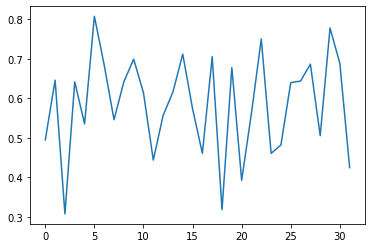

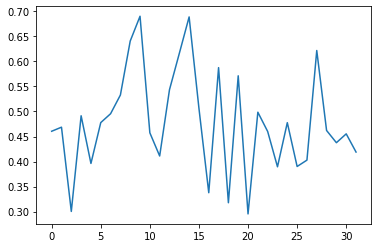

In [184]:
import matplotlib
from matplotlib import pyplot as plt
plt.plot(accs_all)    
plt.show()
plt.plot(f1_all)
plt.show()